In [10]:
# Paso 1: Importar librerías necesarias
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

Recuperación de Información
Nombre: Carlos Córdova
Fecha: 17/12/2024
Realizar los siguientes ejercicios.
Ejecutar el cógido par un corpus mas grande y en ingles.
Especificar las etapas del Bert.
Tokenización y Creación del Corpus:
Aquí se carga un dataset que contiene nombres de países. El código elimina valores nulos y luego crea una lista de cadenas de texto, llamada corpus. Este es el conjunto de "documentos" sobre los cuales el modelo realizará la atención.

In [21]:
# Descargar recursos de NLTK
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
# Paso 2: Cargar el archivo corpus.csv
file_path = '../data/corpus.csv'  # Cambiar si es necesario
corpus = pd.read_csv(file_path)

# Verificar las columnas del archivo y mostrar las primeras filas
print("Columnas disponibles:", corpus.columns)
print(corpus.head())

# Asegurarse de que hay una columna adecuada para el texto (modificar si el nombre es diferente)
text_column = 'Text'  # Cambiar a la columna correcta si es necesario
if text_column not in corpus.columns:
    raise KeyError(f"La columna '{text_column}' no existe en el archivo. Verifique las columnas disponibles.")

# Verificar si hay valores vacíos en la columna de texto
corpus = corpus.dropna(subset=[text_column])
corpus = corpus[corpus[text_column].str.strip() != '']

Columnas disponibles: Index(['Category', 'Text'], dtype='object')
   Category                   Text
0  Greeting    Hello, how are you?
1  Greeting          Good morning!
2  Greeting  Hi, nice to meet you!
3  Greeting             Hey there!
4  Greeting             What's up?


In [29]:
# Paso 3: Procesar texto - Eliminar stop words y tokenizar
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return filtered_tokens

corpus['tokens'] = corpus[text_column].apply(preprocess_text)

# Filtrar filas donde la lista de tokens está vacía
corpus = corpus[corpus['tokens'].apply(len) > 0]
print(corpus.head())

     Category                      Text            tokens
0    Greeting       Hello, how are you?           [hello]
1    Greeting             Good morning!   [good, morning]
2    Greeting     Hi, nice to meet you!  [hi, nice, meet]
3    Greeting                Hey there!             [hey]
5  Small Talk  How's the weather today?  [weather, today]


In [30]:
# Paso 4: Procesamiento con BERT
# Inicializar el modelo y el tokenizador de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

# Generar representaciones vectoriales
def get_bert_embeddings(tokens):
    inputs = tokenizer(tokens, is_split_into_words=True, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Aplicar BERT al corpus
tqdm.pandas()  # Progreso en la aplicación de funciones
corpus['embeddings'] = corpus['tokens'].progress_apply(get_bert_embeddings)

100%|██████████| 29/29 [00:00<00:00, 32.38it/s]


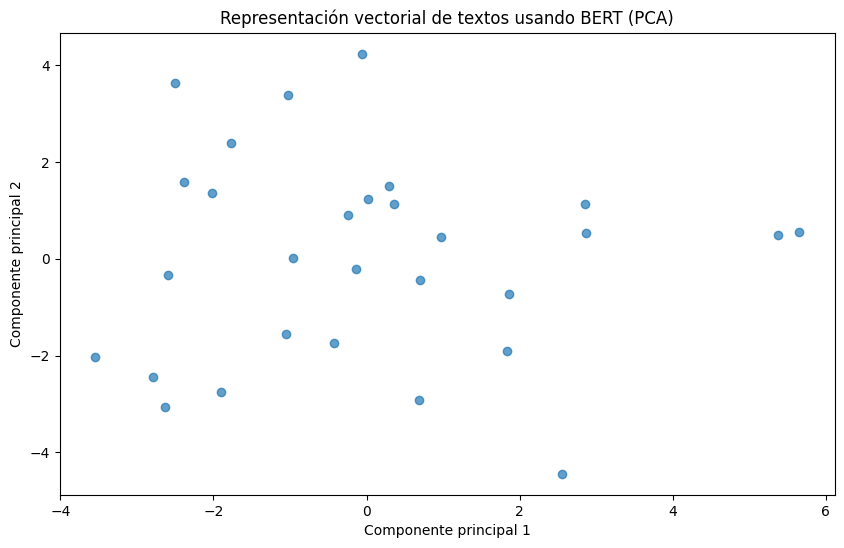

In [31]:
# Paso 5: Visualización de las representaciones vectoriales
# Reducir dimensionalidad con PCA
embeddings = list(corpus['embeddings'])
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Crear gráfica
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
plt.title('Representación vectorial de textos usando BERT (PCA)')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()